<a href="https://colab.research.google.com/github/Ramanarayanan/LLM-Finetuning/blob/main/Unsloth_Qwen2_5_1_5B_bnb_4bit_fineTune_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "unsloth" "trl" "datasets" "accelerate" --quiet

from trl import SFTConfig # Moved from Yq6Hq3mqCiUM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.8/299.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [80]:
# from datasets import load_dataset

# # Replace with path/URL to your own data
# dataset = load_dataset("json", data_files={"train": "train.jsonl"}, split="train")
# print(dataset[0])

from datasets import Dataset

# Replace or expand this list with your own data
data = {
    "instruction": [
        "What is the capital of Chennai City?",
        "Who wrote Romeo and Juliet?",
        "Sum 17 and 25.",
    ],
    "output": [
        "Ambattur.",
        "William Shakespeare.",
        "The sum is 42.",
    ]
}

dataset = Dataset.from_dict(data)
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset1 = split["train"]
val_dataset1 = split["test"]


In [65]:
import random

# Example template questions and answers
questions = [
    "What is the capital of {}?",
    "Who wrote the book titled '{}'?",
    "Sum {} and {}.",
    "What is the color of {}?",
    "Name a famous landmark in {}.",
]

answers = {
    "cities": ["Chennai City", "Italy", "Spain", "Germany", "Japan", "Canada", "Brazil"],
    "books": ["Romeo and Juliet", "1984", "To Kill a Mockingbird", "The Hobbit", "Hamlet"],
    "colors": ["the sky", "an apple", "a banana", "the ocean", "a rose"],
    "landmarks": ["Chennai City", "Italy", "Japan", "Brazil", "Canada"],
}

def generate_data(n):
    instructions = []
    outputs = []

    for _ in range(n):
        q_type = random.choice(questions)

        if "capital" in q_type:
            city = random.choice(answers["cities"])
            instructions.append(q_type.format(city))
            # Simple matching answers for capitals (for demo)
            capitals = {
                "Chennai City": "Ambattur.",
                "Italy": "Rome.",
                "Spain": "Madrid.",
                "Germany": "Berlin.",
                "Japan": "Tokyo.",
                "Canada": "Ottawa.",
                "Brazil": "Brasília.",
            }
            outputs.append(capitals[city])

        elif "wrote" in q_type:
            book = random.choice(answers["books"])
            instructions.append(q_type.format(book))
            authors = {
                "Romeo and Juliet": "William Shakespeare.",
                "1984": "George Orwell.",
                "To Kill a Mockingbird": "Harper Lee.",
                "The Hobbit": "J.R.R. Tolkien.",
                "Hamlet": "William Shakespeare.",
            }
            outputs.append(authors[book])

        elif "Sum" in q_type:
            a, b = random.randint(1, 100), random.randint(1, 100)
            instructions.append(q_type.format(a, b))
            outputs.append(f"The sum is {a + b}.")

        elif "color" in q_type:
            obj = random.choice(answers["colors"])
            instructions.append(q_type.format(obj))
            obj_colors = {
                "the sky": "Blue.",
                "an apple": "Red.",
                "a banana": "Yellow.",
                "the ocean": "Blue.",
                "a rose": "Red."
            }
            outputs.append(obj_colors[obj])

        elif "landmark" in q_type:
            country = random.choice(answers["landmarks"])
            instructions.append(q_type.format(country))
            landmarks = {
                "Chennai City": "Marina Beach.",
                "Italy": "Colosseum.",
                "Japan": "Mount Fuji.",
                "Brazil": "Christ the Redeemer.",
                "Canada": "CN Tower.",
            }
            outputs.append(landmarks[country])

    return {"instruction": instructions, "output": outputs}


# Generate 1000 data points
data = generate_data(1000)
print(len(data["instruction"]), "data points generated")
print("Sample:")
for i in range(3):
    print("Q:", data["instruction"][i])
    print("A:", data["output"][i])


1000 data points generated
Sample:
Q: What is the capital of Spain?
A: Madrid.
Q: Who wrote the book titled '1984'?
A: George Orwell.
Q: Name a famous landmark in Italy.
A: Colosseum.


In [79]:
dataset = Dataset.from_dict(data)
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
val_dataset = split["test"]

In [82]:
def formatting_func(examples):
    # Each examples is a dict of columns: {'instruction':..., 'output':...}
    # Return a list of joined input-output strings (one for each sample)
    return [
        f"Instruction: {instr}\nResponse: {resp}"
        for instr, resp in zip(examples["instruction"], examples["output"])
    ]


In [4]:
!pip install unsloth

In [83]:
from unsloth import FastLanguageModel

MODEL_NAME = "unsloth/Qwen2.5-1.5B-bnb-4bit"  # Or: "unsloth/Qwen1.5-1.5B-Chat-bnb-4bit"
MAX_SEQ_LENGTH = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME,
    max_seq_length = MAX_SEQ_LENGTH,
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)



==((====))==  Unsloth 2025.8.1: Fast Qwen2 patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [84]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,                       # LoRA rank, tune as needed
    target_modules = ["q_proj","k_proj","v_proj","o_proj",
                      "gate_proj","up_proj","down_proj"],  # Standard for Qwen
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    max_seq_length = MAX_SEQ_LENGTH,
    use_rslora = False,
)


In [85]:
from trl import SFTTrainer, SFTConfig


In [86]:
trainer = SFTTrainer(
    model = model,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    formatting_func=formatting_func,
    args = SFTConfig(
        max_length = MAX_SEQ_LENGTH,
        per_device_train_batch_size = 2,         # Start small for Colab
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 60,                          # Increase for real training
        logging_steps = 1,
        output_dir = "outputs",
        optim = "adamw_8bit",
        seed = 3407,
        num_train_epochs = 4,
        eval_strategy="steps",

        save_steps= 0.0415, # good for 2 epochs
        eval_steps=40,

    ),
)
trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Unsloth: Tokenizing ["text"]:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2 | Num Epochs = 60 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Step,Training Loss,Validation Loss
40,0.087700,2.124774


TrainOutput(global_step=60, training_loss=1.2361987167969346, metrics={'train_runtime': 61.3987, 'train_samples_per_second': 7.818, 'train_steps_per_second': 0.977, 'total_flos': 15307837931520.0, 'train_loss': 1.2361987167969346})

In [54]:
sfconfig = SFTConfig(
        max_length = MAX_SEQ_LENGTH,
        per_device_train_batch_size = 2,         # Start small for Colab
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 60,                          # Increase for real training
        logging_steps = 1,
        output_dir = "outputs",
        optim = "adamw_8bit",
        seed = 3407,
        num_train_epochs = 40,
        eval_strategy="steps",     # To log eval loss, if validation set supplied
        eval_steps=40,

    ),

In [55]:
from trl import SFTTrainer
# from trl import SFTConfig # Moved to a cell before the one that uses it

trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    tokenizer = tokenizer,
    formatting_func=formatting_func,
    args = sfconfig,
)
trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/3 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3 | Num Epochs = 3 | Total steps = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Step,Training Loss
1,3.195800
2,3.195800
3,2.993700


TrainOutput(global_step=3, training_loss=3.1284259955088296, metrics={'train_runtime': 1.4853, 'train_samples_per_second': 6.06, 'train_steps_per_second': 2.02, 'total_flos': 1435109806080.0, 'train_loss': 3.1284259955088296})

In [87]:
logs = trainer.state.log_history

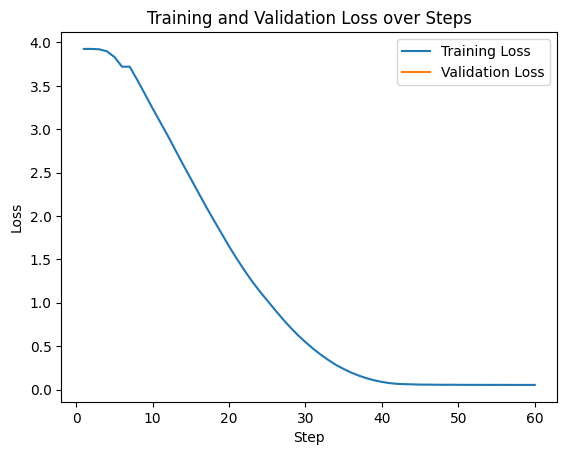

In [88]:
# Example: Extract train/val loss from trainer log history
train_loss = [log['loss'] for log in logs if 'loss' in log]
train_steps = [log['step'] for log in logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
val_steps = [log['step'] for log in logs if 'eval_loss' in log]

import matplotlib.pyplot as plt
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(val_steps, val_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.show()


In [89]:
# Hugging Face save format
model.save_pretrained("outputs/finetuned_qwen")
tokenizer.save_pretrained("outputs/finetuned_qwen")


('outputs/finetuned_qwen/tokenizer_config.json',
 'outputs/finetuned_qwen/special_tokens_map.json',
 'outputs/finetuned_qwen/vocab.json',
 'outputs/finetuned_qwen/merges.txt',
 'outputs/finetuned_qwen/added_tokens.json',
 'outputs/finetuned_qwen/tokenizer.json')

In [90]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

In [91]:
model.push_to_hub("RamAi24/Qwen1.5-0.5B-Chat-bnb-4bit_demo")
tokenizer.push_to_hub("RamAi24/Qwen1.5-0.5B-Chat-bnb-4bit_demo")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...pszuxhz3k/adapter_model.safetensors:   0%|          | 45.7kB / 73.9MB            

Saved model to https://huggingface.co/RamAi24/Qwen1.5-0.5B-Chat-bnb-4bit_demo


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp4atrc526/tokenizer.json       : 100%|##########| 11.4MB / 11.4MB            

In [92]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from unsloth import FastLanguageModel

model_dir = "outputs/finetuned_qwen"  # update if your path is different

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load the model using FastLanguageModel for compatibility with unsloth optimizations
model, _ = FastLanguageModel.from_pretrained(
    model_name = model_dir,
    max_seq_length = MAX_SEQ_LENGTH, # Reuse the previously defined MAX_SEQ_LENGTH
    load_in_4bit = True, # Load in 4-bit as it was trained
)

==((====))==  Unsloth 2025.8.1: Fast Qwen2 patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [93]:
prompt = "Instruction: What is the capital of Chennai City?\nResponse:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")


In [94]:
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=True,
        temperature=0.8,
        top_p=0.95,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    print("Model Output:")
    print(decoded)


Model Output:
Instruction: What is the capital of Chennai City?
Response: Ambattur.


In [ ]:
!pip install bitsandbytes

In [33]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from unsloth import FastLanguageModel # Import FastLanguageModel

# Load model and tokenizer
model_dir = "RamAi24/Qwen1.5-0.5B-Chat-bnb-4bit_demo"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
# Load the model using FastLanguageModel for compatibility with unsloth optimizations
model, _ = FastLanguageModel.from_pretrained(
    model_name = model_dir,
    max_seq_length = MAX_SEQ_LENGTH, # Reuse the previously defined MAX_SEQ_LENGTH
    load_in_4bit = True, # Load in 4-bit as it was trained
)

# Evaluation data (prompts and ground-truth outputs)
eval_data = {
    "instruction": [
        "What is the capital of Chennai City?",
        "Who wrote Romeo and Juliet?",
        "Sum 17 and 25.",
    ],
    "output": [
        "Ambattur.",
        "William Shakespeare.",
        "The sum is 42.",
    ]
}

# Generate predictions
model.eval()
predicted = []
for instr in eval_data["instruction"]:
    input_text = f"Instruction: {instr}\nResponse:"
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    # Extract answer only (remove prompt)
    pred = decoded.split("Response:")[-1].strip()
    predicted.append(pred)
print(predicted)

==((====))==  Unsloth 2025.8.1: Fast Qwen2 patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
['Chennai is the capital of Tamil Nadu state in India.', 'William Shakespeare wrote Romeo and Juliet.', '42']


In [34]:
from sklearn.metrics import precision_recall_fscore_support

# Exact match accuracy
labels = [ans.strip().lower() for ans in eval_data["output"]]
preds = [pred.strip().lower() for pred in predicted]
exact_match = [l == p for l, p in zip(labels, preds)]
accuracy = sum(exact_match) / len(exact_match)

# As a demonstration, string-based macro precision/recall/f1 (for more advanced tasks, use more sophisticated metric)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
